Analyzing write-to-read timing on channels: low=18, high=13
Analyzing write-to-read timing for constant pulse sequence
Sequence length: 1000 pulses
Processing operation 1/1000
Processing operation 101/1000
Processing operation 101/1000
Processing operation 201/1000
Processing operation 201/1000
Processing operation 301/1000
Processing operation 301/1000
Processing operation 401/1000
Processing operation 401/1000
Processing operation 501/1000
Processing operation 501/1000
Processing operation 601/1000
Processing operation 601/1000
Processing operation 701/1000
Processing operation 701/1000
Processing operation 801/1000
Processing operation 801/1000
Processing operation 901/1000
Processing operation 901/1000


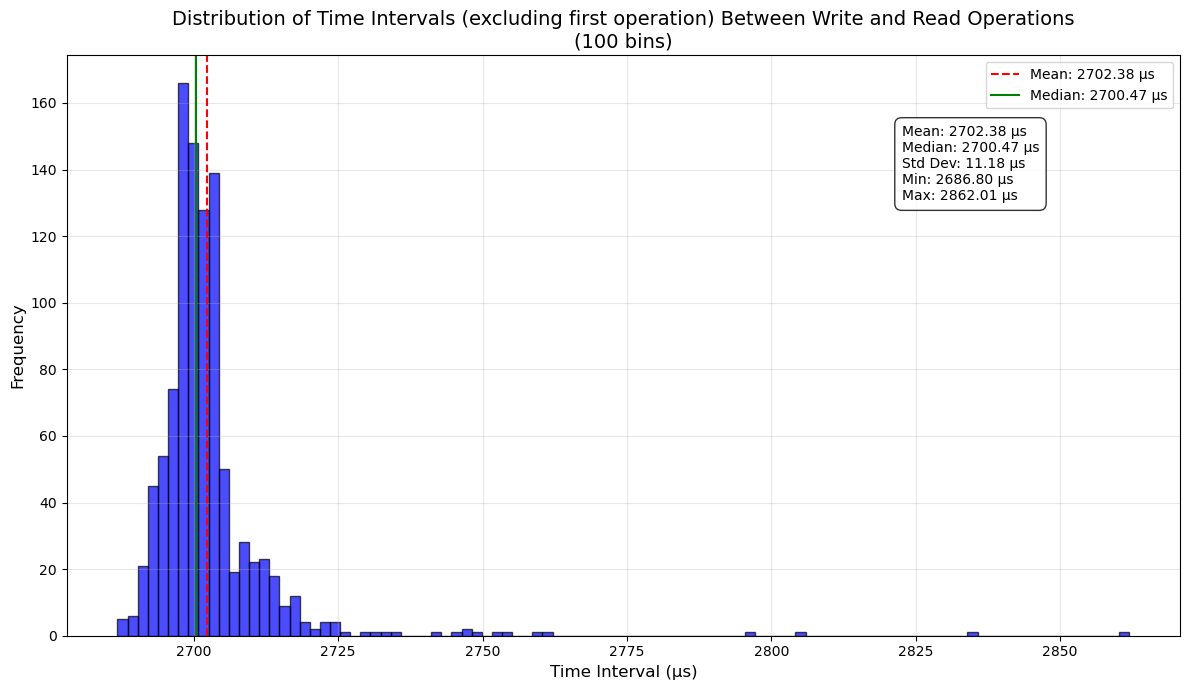


Write-to-Read Timing Statistics (excluding first operation):
Number of operations: 999
Average interval: 2702.377 μs
Minimum interval: 2686.799 μs
Maximum interval: 2862.007 μs
Timing variation: 175.208 μs

All intervals including first (μs):
Operation 1 (Pulse 1): 2734.278 μs
Operation 2 (Pulse 2): 2862.007 μs
Operation 3 (Pulse 3): 2747.853 μs
Operation 4 (Pulse 4): 2716.354 μs
Operation 5 (Pulse 5): 2702.448 μs
Operation 6 (Pulse 6): 2710.803 μs
Operation 7 (Pulse 7): 2703.129 μs
Operation 8 (Pulse 8): 2716.964 μs
Operation 9 (Pulse 9): 2699.001 μs
Operation 10 (Pulse 10): 2703.350 μs
Operation 11 (Pulse 11): 2699.282 μs
Operation 12 (Pulse 12): 2722.155 μs
Operation 13 (Pulse 13): 2711.435 μs
Operation 14 (Pulse 14): 2705.834 μs
Operation 15 (Pulse 15): 2709.962 μs
Operation 16 (Pulse 16): 2700.754 μs
Operation 17 (Pulse 17): 2710.082 μs
Operation 18 (Pulse 18): 2701.496 μs
Operation 19 (Pulse 19): 2708.179 μs
Operation 20 (Pulse 20): 2714.401 μs
Operation 21 (Pulse 21): 2700.414 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pyarc2
from pyarc2 import Instrument, find_ids, DataMode
import pulse_gen

def analyze_write_to_read_timing(
    instrument, 
    low, 
    high, 
    sequence_config=None,
    read_voltage=0.2,
    debug=False
):
    """
    Analyze the timing between write pulses and read operations.
    
    Parameters:
    -----------
    instrument : Instrument
        PyArC2 instrument instance
    low : int
        Low channel number
    high : int
        High channel number
    sequence_config : dict
        Dictionary containing sequence configuration
    read_voltage : float
        Voltage used for reading resistance
    debug : bool
        Print debug information if True
        
    Returns:
    --------
    dict
        Dictionary containing write-to-read timing information
    """
    # Default configuration if none provided
    if sequence_config is None:
        sequence_config = {
            'type': 'constant',
            'params': {
                'voltage': 1.0,
                'count': 10,
                'pulse_width': 100_000
            },
            'inter_pulse_delay': 500_000
        }
    
    # Extract parameters
    sequence_type = sequence_config.get('type', 'constant')
    params = sequence_config.get('params', {})
    inter_pulse_delay = sequence_config.get('inter_pulse_delay', 500000)
    
    # Generate pulse sequence based on configuration type
    pulse_sequence = pulse_gen.create_pulse_sequence(sequence_type, **params)
    
    if debug:
        print(f"Analyzing write-to-read timing for {sequence_type} pulse sequence")
        print(f"Sequence length: {len(pulse_sequence)} pulses")
    
    # Arrays to store timing information
    write_timestamps = []
    read_timestamps = []
    write_to_read_intervals = []
    
    # Apply each pulse and measure timing one at a time to get actual hardware timing
    for idx, (voltage, duration) in enumerate(pulse_sequence):
        if debug and idx % 100 == 0:
            print(f"Processing operation {idx+1}/{len(pulse_sequence)}")
            
        # Clear any previous commands
        instrument.ground_all()
        instrument.execute()
        instrument.wait()
        
        # Apply write pulse
        instrument.pulse_one(low, high, voltage, duration)
        
        # Execute just the write command and wait for completion
        instrument.execute()
        instrument.wait()
        
        # Start timing immediately after write completes
        start_time = time.perf_counter()
        
        # Perform read
        instrument.generate_read_train(
            lows=[low],
            highs=[high],
            vread=read_voltage,
            nreads=1,
            inter_nanos=0,
            ground=False
        )
        
        # Execute read command
        instrument.execute()
        instrument.wait()
        
        # Measure the time after read completes
        end_time = time.perf_counter()
        
        # Calculate and store the interval in microseconds
        interval = (end_time - start_time) * 1_000_000
        write_to_read_intervals.append(interval)
        
        # Apply the inter-pulse delay
        if inter_pulse_delay > 0:
            time.sleep(inter_pulse_delay / 1_000_000_000)  # Convert ns to seconds
    
    # Process results (current readings) - simplified version
    results = []
    for idx, current_data in enumerate(instrument.get_iter(DataMode.All)):
        if idx < len(pulse_sequence):
            voltage, duration = pulse_sequence[idx]
            current = current_data[0][high]
            
            # Calculate resistance
            resistance = read_voltage / current if abs(current) > 1e-12 else float('inf')
            
            results.append({
                'voltage': voltage,
                'current': current,
                'resistance': resistance
            })
    
    # Return timing data
    return {
        'write_to_read_intervals': write_to_read_intervals,
        'results': results,
        'pulse_sequence': pulse_sequence
    }

def visualize_write_to_read_timing(timing_data, skip_first=True, num_bins=30):
    """
    Create a histogram of write-to-read time intervals.
    
    Parameters:
    -----------
    timing_data : dict
        Timing data from analyze_write_to_read_timing
    skip_first : bool
        Whether to skip the first operation interval (often has initialization overhead)
    num_bins : int
        Number of bins for the histogram (higher = more detail)
    """
    # Get all intervals
    all_intervals = timing_data['write_to_read_intervals']
    
    # Skip the first interval if requested and if we have enough data
    if skip_first and len(all_intervals) > 1:
        intervals = all_intervals[1:]  # Skip first interval
        title_prefix = "Distribution of Time Intervals (excluding first operation)"
    else:
        intervals = all_intervals
        title_prefix = "Distribution of Time Intervals"
    
    # Create figure for histogram
    plt.figure(figsize=(12, 7))
    
    # Calculate optimal bins
    if len(intervals) > 100:
        # For large datasets, use Freedman-Diaconis rule (often works better for large datasets)
        bin_width = 2 * (np.percentile(intervals, 75) - np.percentile(intervals, 25)) / (len(intervals) ** (1/3))
        range_min, range_max = np.min(intervals), np.max(intervals)
        adaptive_bins = max(10, int((range_max - range_min) / bin_width)) if bin_width > 0 else num_bins
        actual_bins = min(adaptive_bins, 100)  # Cap at 100 bins for readability
    else:
        actual_bins = num_bins
    
    # Plot histogram of time intervals with more bins
    counts, bin_edges, patches = plt.hist(intervals, bins=actual_bins, color='blue', 
                                          alpha=0.7, edgecolor='black', density=False)
    
    plt.title(f'{title_prefix} Between Write and Read Operations\n({actual_bins} bins)', fontsize=14)
    plt.xlabel('Time Interval (μs)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add statistical information
    mean_interval = np.mean(intervals)
    median_interval = np.median(intervals)
    std_interval = np.std(intervals)
    min_interval = np.min(intervals)
    max_interval = np.max(intervals)
    
    stats_text = (f"Mean: {mean_interval:.2f} μs\n"
                 f"Median: {median_interval:.2f} μs\n"
                 f"Std Dev: {std_interval:.2f} μs\n"
                 f"Min: {min_interval:.2f} μs\n"
                 f"Max: {max_interval:.2f} μs")
    
    plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
                 fontsize=10)
    
    # Add a vertical line for the mean
    plt.axvline(mean_interval, color='red', linestyle='--', linewidth=1.5, 
                label=f'Mean: {mean_interval:.2f} μs')
    
    # Add a vertical line for the median
    plt.axvline(median_interval, color='green', linestyle='-', linewidth=1.5, 
                label=f'Median: {median_interval:.2f} μs')
    
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

def main():
    # Initialize the instrument
    ids = find_ids()
    if len(ids) == 0:
        print('No ArC2 device found')
        return
    
    # Connect to the first available ArC2 device
    # Update the firmware path as needed
    arc = Instrument(ids[0], '/home/abaigol/.local/share/arc2control/firmware/efm03_20240918.bin')

    
    # Define channels to use
    low = 18
    high = 13
    
    print(f"Analyzing write-to-read timing on channels: low={low}, high={high}")
    
    # Set up a test configuration - try different ones
    set_reset_config = {
        'type': 'set_reset',
        'params': {
            'set_v': 1.2,
            'reset_v': -1.2,
            'pulse_width': 100_000,
            'cycles': 5
        },
        'inter_pulse_delay': 500_000
    }

    constant_config = {
        'type': 'constant',
        'params': {
            'voltage': 1.0,
            'count': 1000,
            'pulse_width': 100_000
        },
        'inter_pulse_delay': 0
    }
    
    # Choose which configuration to use
    active_config = constant_config
    
    # Run the timing analysis
    timing_data = analyze_write_to_read_timing(
        arc, 
        low=low, 
        high=high, 
        sequence_config=active_config,
        read_voltage=0.2,
        debug=True
    )
    
    # Visualize the timing distribution
    visualize_write_to_read_timing(timing_data, skip_first=True, num_bins=100)
    
    # Print timing statistics
    intervals = timing_data['write_to_read_intervals']
    intervals_no_first = intervals[1:] if len(intervals) > 1 else intervals

    print("\nWrite-to-Read Timing Statistics (excluding first operation):")
    print(f"Number of operations: {len(intervals_no_first)}")
    print(f"Average interval: {np.mean(intervals_no_first):.3f} μs")
    print(f"Minimum interval: {np.min(intervals_no_first):.3f} μs")
    print(f"Maximum interval: {np.max(intervals_no_first):.3f} μs")
    print(f"Timing variation: {(np.max(intervals_no_first) - np.min(intervals_no_first)):.3f} μs")

    print("\nAll intervals including first (μs):")
    for i, interval in enumerate(intervals):
        operation_type = "SET" if i % 2 == 0 and active_config['type'] == 'set_reset' else "RESET" if active_config['type'] == 'set_reset' else f"Pulse {i+1}"
        print(f"Operation {i+1} ({operation_type}): {interval:.3f} μs")

if __name__ == "__main__":
    main()